In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pygus import Species, latlng_array_to_xy

In [2]:
import os
import math
import random
import logging
import pandas as pd
import numpy as np
from typing import Union
from pkg_resources import resource_filename

from shapely.geometry import Polygon, MultiPolygon, Point



def tree_population_from_geojson(
    geojson: Union[Polygon, MultiPolygon],
    num_trees,
    allometrics = None,
    dbh_range=[10, 15], # cm)
    species={"Deciduous": 0.8, "Conifers": 0.2}, # % conifers
    condition_weights=[0.6, 0.3, 0.1, 0.0, 0.0], # excellent, good, fair, critical, dying
) -> pd.DataFrame:
    """This function generates a population of trees, with possibility for modifying the ranges of
    the different parameters. The trees are randomly distributed in a square of side length equal
    to the square root of the area in m2. The trees are assigned a species, a condition, a dbh, a
    height and a crown width.

    Args:
        geojson (dict): A geojson dictionary containing the coordinates of the area where the trees will be generated.
        num_trees (int): The number of trees to generate.

    Returns:
        pd.DataFrame: Returns a tree population which can be used as input for the model.
    """
    df = pd.DataFrame()
    _generate_locations_in_geojson(df, geojson, num_trees)

    #TODO: What do we do with this now?
    if allometrics is None:
        allometrics = Species(resource_filename("pygus", "gus/inputs/allometrics.json"))

    evergreen_pc = _get_evergreen_percentage(species, allometrics)

    return generate_population_features(
        df, allometrics, dbh_range, species, condition_weights
    )


# Ideally, this function could take a dataframe, and add any missing elements needed for the simulation
# id, dbh, height, crownW, species, condition, xpos, ypos, lat, lng
def generate_population_features(
    df: pd.DataFrame,
    allometrics: Species,
    dbh_range=[10, 15],
    species={"Deciduous": 0.8, "Conifers": 0.2}, # % conifers
    condition_weights=[0.6, 0.3, 0.1, 0.0, 0.0],
) -> pd.DataFrame:
    """This function generates a population of trees, with possibility for modifying the ranges of
    the different parameters. The trees are randomly distributed in a square of side length equal
    to the square root of the area in m2. The trees are assigned a species, a condition, a dbh, a
    height and a crown width.

    Args:
        df (pd.DataFrame): _description_
        location (_type_): _description_
        area_m2 (_type_): _description_
        dbh_range (list, optional): _description_. Defaults to [10, 15].
        conifer_percentage (float, optional): _description_. Defaults to 0.2.
        condition_weights (list, optional): _description_. Defaults to [0.6, 0.3, 0.1, 0.0, 0.0].

    Returns:
        pd.DataFrame: Returns a tree population which can be used as input for the model.
    """
    ### id,lat,lng

    ## id,lat,lng,xpos,ypos
    if "xpos" not in df.columns or "ypos" not in df.columns:
        latlng_array_to_xy(df, "lat", "lng")
    
    ## id,lat,lng,xpos,ypos,dbh
    if "dbh" not in df.columns:
        df["dbh"] = np.around(np.random.uniform(*dbh_range, len(df)), 3)
        print(df["dbh"].mean())
        if df["dbh"].mean() < 2:
            SAPLING_HEIGHT = [0.3, 0.5]
            df["height"] = np.around(np.random.uniform(*SAPLING_HEIGHT, len(df)), 3)

    ## id,lat,lng,xpos,ypos,dbh,species
    if "species" not in df.columns:
        s = list(species.keys())
        # species is a dict of str to float
        df["species"] = random.choices(
            s, weights=list(species.values()),
            k=len(df),
        )

    if "height" not in df.columns:
        all_species = list(species.keys())
        equations = {}
        for s in all_species:
            equations[s] = allometrics.get_eqn(allometrics.fuzzymatch(s), "height")
        print(equations)
        df["height"] = df.apply(lambda row: equations[row["species"]](row["dbh"]), axis=1)

    ## id,lat,lng,xpos,ypos,dbh,species,condition
    if "condition" not in df.columns:
        df["condition"] = random.choices(
            ["excellent", "good", "fair", "critical", "dying"],
            weights=condition_weights,
            k=len(df),
        )

    if "id" not in df.columns:
        df.index.name = 'id'
        df.reset_index(inplace=True)

    column_out_order = ["id", "species", "dbh", "lat", "lng", "condition", "xpos", "ypos"]
    df.reindex(columns=column_out_order)
    return df
        
def _generate_locations_in_geojson(df, polygon: Union[Polygon, MultiPolygon], num_points):
    if polygon.geom_type == "Polygon":
        min_x, min_y, max_x, max_y = polygon.bounds
    elif polygon.geom_type == "MultiPolygon":
        min_x, min_y, max_x, max_y = polygon.bounds
    points = []

    while len(points) < num_points:
        random_point = Point(
            [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        )
        if polygon.contains(random_point):
            points.append(random_point)

    df["lat"] = [point.y for point in points]
    df["lng"] = [point.x for point in points]

def _get_evergreen_percentage(species_dict, allometrics: Species):
    # check species_dict values total 1
    if not sum(species_dict.values()) - 1.0 < 1e-6:
        raise ValueError(f"Species dictionary values must sum to 1, got {sum(species_dict.values())}")
    
    evergreens = 0
    for species in species_dict:
        fuzzy = allometrics.fuzzymatch(species)
        if fuzzy is not None:
            if allometrics.is_evergreen(fuzzy):
                print(f"{species} is evergreen ({species_dict[species] * 100:.2f}%)")
                evergreens += species_dict[species]
        else:
            print(f"Species {species} not found in allometrics.json")

    logging.debug(f"Evergreen percentage: {evergreens * 100:.2f}%")
    return evergreens


def _generate_locations_in_square_area(
    df: pd.DataFrame, initial_coordinates, area_m2: float
) -> pd.DataFrame:
    lat = initial_coordinates[0]
    lng = initial_coordinates[1]
    half_side_length = np.sqrt(area_m2) / 2
    R = 6371e3  # Earth radius in metres

    bottom_left = [
        lat - (half_side_length / R) * (180 / math.pi),
        lng - (half_side_length / R) * (180 / math.pi) / math.cos(lat * math.pi / 180),
    ]
    top_right = [
        lat + (half_side_length / R) * (180 / math.pi),
        lng + (half_side_length / R) * (180 / math.pi) / math.cos(lat * math.pi / 180),
    ]
    bbox = [*bottom_left, *top_right]

    # for each element of the dataframe, assign a random lat and lng
    for i in range(len(df)):
        lat = np.random.uniform(bbox[1], bbox[3])
        lng = np.random.uniform(bbox[0], bbox[2])
        df.loc[i, "lat"] = lat
        df.loc[i, "lng"] = lng

def _bounding_box_to_geojson(bbox):
    min_lat, min_lon, max_lat, max_lon = bbox
    return {
        "type": "Polygon",
        "coordinates": [
            [
                [min_lon, min_lat],
                [min_lon, max_lat],
                [max_lon, max_lat],
                [max_lon, min_lat],
                [min_lon, min_lat],
            ]
        ],
    }

In [3]:
species_dist = {
  "Acer campestre": 0.05,
  "Betula pendula": 0.05,
  "Betula pubescens": 0.05,
  "Carpinus betulus": 0.05,
  "Cornus sanguinea": 0.07,
  "Corylus avellana": 0.1,
  "Euonymus europaeus": 0.05,
  "Malus sylvestris": 0.05,
  "Prunus avium": 0.05,
  "Prunus spinosa": 0.05,
  "Quercus petraea": 0.02,
  "Quercus robur": 0.02,
  "Rosa canina": 0.05,
  "Salix caprea": 0.05,
  "Salix cinerea": 0.05,
  "Sambucus nigra": 0.07,
  "Sorbus aria": 0.05,
  "Sorbus torminalis": 0.05,
  "Tilia cordata": 0.02,
  "Viburnum opulus": 0.05
}

species = species_dist.keys()
ratios = species_dist.values()

In [4]:
sites = [
    {"name": "Forest of Thanks", "trees": 30000, "lat": 51.546514, "lng": 0.126283, "shape": "input/forest_of_thanks.geojson"},
    {"name": "Castle Green Forest", "trees": 1400, "lat": 51.532997, "lng": 0.119295, "shape": "input/castle_green_forest.geojson"},
    {"name": "Thames View Junior", "trees": 1200, "lat": 51.526769, "lng": 0.102509, "shape": "input/thames_view_junior.geojson"},
]

In [5]:
from shapely import from_geojson
from pkg_resources import resource_filename
allometrics_path = resource_filename("pygus", "gus/inputs/allometrics_extended.json")
species_allometrics = Species(allometrics_path)
species_map = {}
# check how many are in our allometrics file, and highlight ones that are not
for s in species:
    species_map[s] = species_allometrics.fuzzymatch(s)

print(species_map)

Found cornus sanguinea to be the best match for the input Rosa canina with a score of 59.
Found prunus virginiana to be the best match for the input Viburnum opulus with a score of 53.
{'Acer campestre': 'acer campestre', 'Betula pendula': 'betula pendula', 'Betula pubescens': 'betula pubescens', 'Carpinus betulus': 'carpinus betulus', 'Cornus sanguinea': 'cornus sanguinea', 'Corylus avellana': 'corylus avellana', 'Euonymus europaeus': 'fraxinus excelsior', 'Malus sylvestris': 'malus sylvestris', 'Prunus avium': 'prunus avium', 'Prunus spinosa': 'prunus spinosa', 'Quercus petraea': 'quercus petraea', 'Quercus robur': 'quercus robur', 'Rosa canina': 'decidu', 'Salix caprea': 'salix caprea', 'Salix cinerea': 'salix cinerea', 'Sambucus nigra': 'quercus nigra', 'Sorbus aria': 'sorbus aria', 'Sorbus torminalis': 'sorbus torminalis', 'Tilia cordata': 'tilia cordata', 'Viburnum opulus': 'decidu'}


In [6]:
for site in sites:
    # for each site, generate a population, load the geojson
    shapely_geojson = from_geojson(open(site["shape"]).read())
    print(shapely_geojson)


    # generate population within each geojson
    site_df = tree_population_from_geojson(
        shapely_geojson, 
        site["trees"], 
        allometrics=species_allometrics,
        species=species_dist,
        dbh_range=[0.5, 1.5],
        condition_weights=[0.8, 0.2, 0.0, 0.0, 0.0]
    )
    site["df"] = site_df
    
    site_df.to_csv(f"output/{site['name']}.csv".replace(" ", "_"), index=False)

    print(site_df["dbh"].describe())
    print(site_df["height"].describe())
    # print the top 5 rows sorted by height
    print(site_df.sort_values("height", ascending=False).head(5))


# trees_CGf = from_geojson(open(sites[1]["shape"]).read())
# trees_TVj = from_geojson(open(sites[2]["shape"]).read())
    


MULTIPOLYGON (((0.1273308912034281 51.5468999931085, 0.1271949353328807 51.546920017465595, 0.1270589794849286 51.54694004182977, 0.1269337569938784 51.546944491689885, 0.1268228456405041 51.54692891717414, 0.1267927184590292 51.54692446731397, 0.1267198891399346 51.54690925097901, 0.1266089777905961 51.5468736520688, 0.1265231109452998 51.54683137833294, 0.1264730219491241 51.54680022924006, 0.1264229329518969 51.54675350556042, 0.1265231109452998 51.54673125617239, 0.1265875110993875 51.546706781814464, 0.1266698001644784 51.54666673286658, 0.1267342003114891 51.54663558364385, 0.126784636621629 51.54660633642547, 0.1268493840722584 51.54664828743128, 0.1269717234042957 51.546705490070536, 0.1271566739812329 51.54682387846472, 0.1273308912034281 51.5468999931085)), ((0.1270965669326927 51.546583257401835, 0.1272074782831112 51.546545433296075, 0.1272647228496453 51.54650760915803, 0.1273112340611533 51.54645643527161, 0.1273505897013365 51.546403036373135, 0.1275402123312119 51.54644

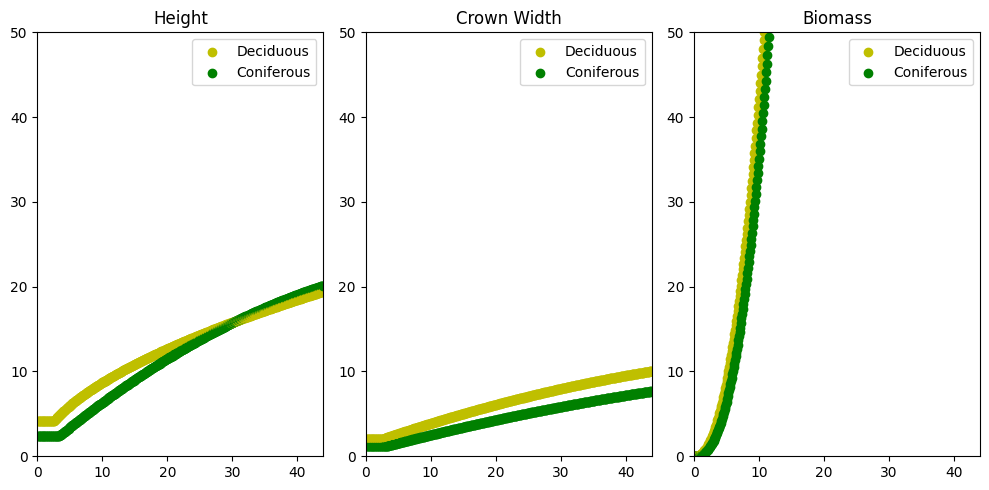

In [7]:
import matplotlib.pyplot as plt
import numpy as np

h_decidu = species_allometrics.get_eqn("decidu", "height")
h_conif = species_allometrics.get_eqn("conifer", "height")

biomass_decidu = species_allometrics.get_eqn_biomass("decidu")
biomass_conif = species_allometrics.get_eqn_biomass("conifer")

crownWidth_decidu = species_allometrics.get_eqn("decidu", "crown_width")
crownWidth_conif = species_allometrics.get_eqn("conifer", "crown_width")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # Create figure and subplots outside the loop

# Set titles
axs[0].set_title("Height")
axs[1].set_title("Crown Width")
axs[2].set_title("Biomass")

# Set x and y limits
for ax in axs:
    ax.set_xlim(0, 44)
    ax.set_ylim(0, 50)

# Plot data
for i in np.arange(0.1, 44, 0.1):
    axs[0].scatter(i, h_decidu(i), color='y')  # Plot height for deciduous
    axs[0].scatter(i, h_conif(i), color='g')  # Plot height for coniferous
    axs[1].scatter(i, crownWidth_decidu(i), color='y')  # Plot crown width for deciduous
    axs[1].scatter(i, crownWidth_conif(i), color='g')  # Plot crown width for coniferous
    axs[2].scatter(i, biomass_decidu(i), color='y')  # Plot biomass for deciduous
    axs[2].scatter(i, biomass_conif(i), color='g')  # Plot biomass for conifer

# Set legends
axs[0].legend(["Deciduous", "Coniferous"])
axs[1].legend(["Deciduous", "Coniferous"])
axs[2].legend(["Deciduous", "Coniferous"])

plt.tight_layout()
plt.show()

In [8]:
# Below I'll plot the distributions of: DBH, height, and lat/lng
def plot_dbh_height_and_latlng(df):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("DBH, Height, and Lat/Lng Distributions")
    axs[0].hist(df["dbh"], bins=20)
    axs[0].set_title("DBH Distribution")
    axs[1].hist(df["height"], bins=20)
    axs[1].set_title("Height Distribution")
    axs[2].scatter(df["lat"], df["lng"])
    axs[2].set_title("Tree Locations")
    plt.show()

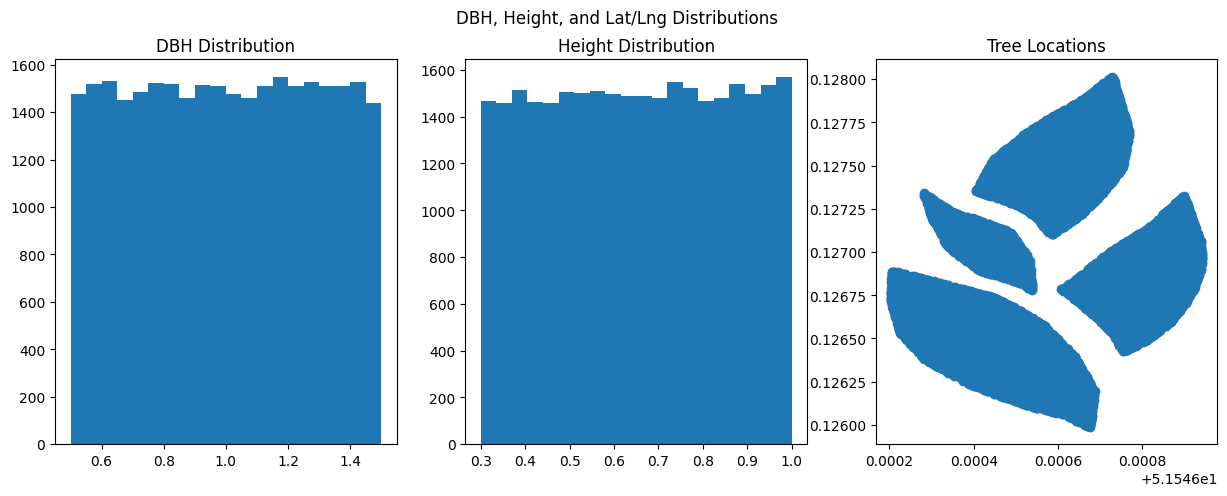

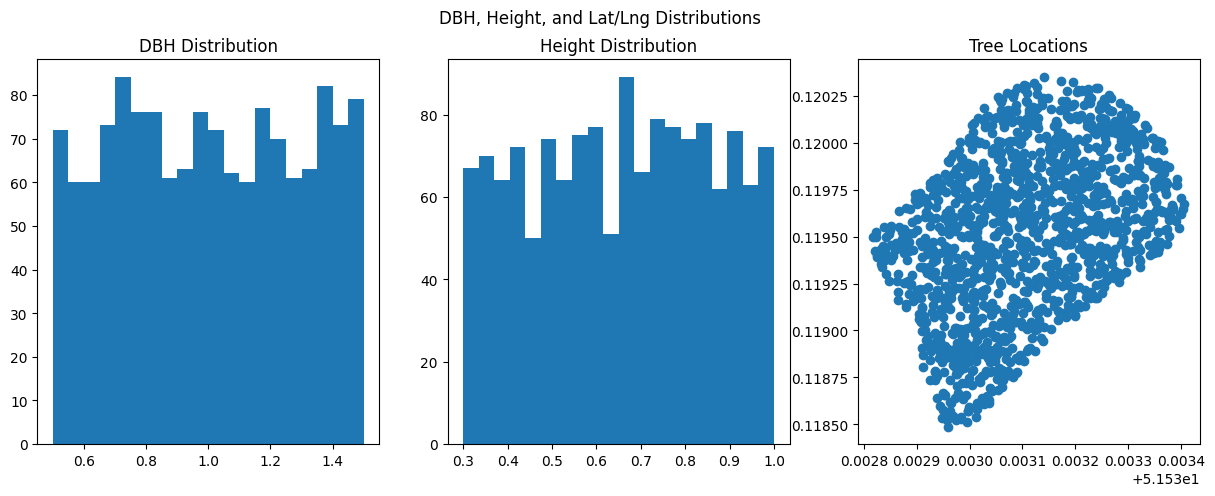

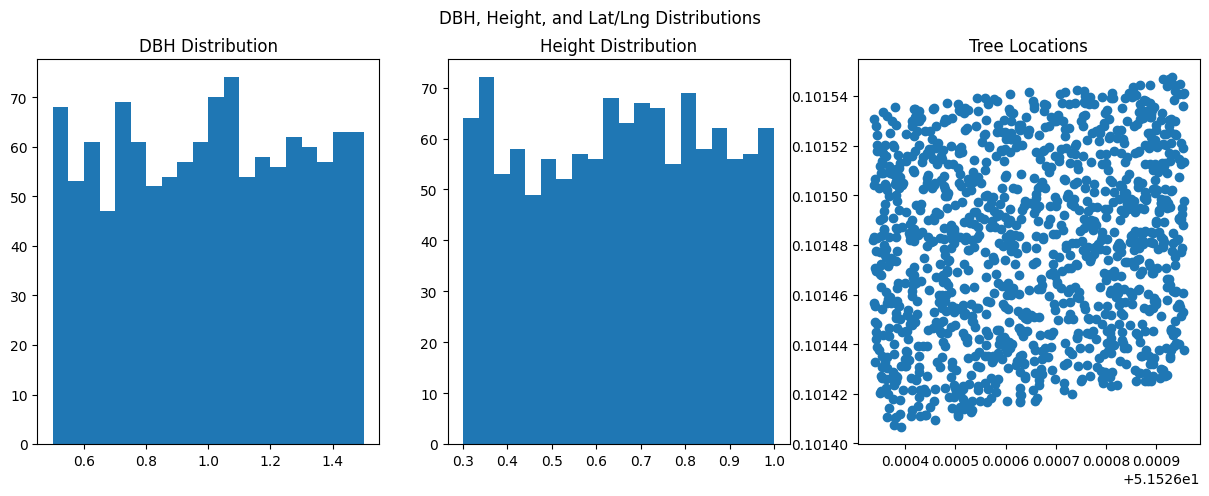

In [9]:
for site in sites:
    df = pd.read_csv(f"output/{site['name']}.csv")
    plot_dbh_height_and_latlng(df)

In [10]:
# TODO
from pygus import Urban, SiteConfig, ScenarioConfig, WeatherConfig

df = sites[1]["df"]
print(df.head())



# SITE
site_config = SiteConfig(
    total_m2=1000,
    impervious_m2=0,
    pervious_m2=1000,
    weather=WeatherConfig(
        growth_season_mean=155,
        growth_season_var=7,
    ),
    tree_density_per_ha=5,
    project_site_type="park",
)

# SCENARIO
scenario_config = ScenarioConfig(
    1,
    is_crownsunexposure_fixed=1,
    time_horizon_years=50,
)

# Initialise the model environment
urban = Urban(
    population=df,
    species_allometrics=species_allometrics,
    site_config=site_config,
    scenario=scenario_config,
)
urban.run()

   id        lat       lng  xpos  ypos    dbh  height           species  \
0   0  51.532975  0.119706    83    17  0.802   0.500      Salix caprea   
1   1  51.533134  0.119046    38    36  0.704   0.348  Cornus sanguinea   
2   2  51.533033  0.118910    28    25  1.434   0.329     Salix cinerea   
3   3  51.532978  0.119181    46    19  1.085   0.432  Cornus sanguinea   
4   4  51.533202  0.119273    54    43  1.009   0.326   Quercus petraea   

   condition  
0       good  
1  excellent  
2  excellent  
3       good  
4       good  
Found prunus virginiana to be the best match for the input Viburnum opulus with a score of 53.
Found prunus virginiana to be the best match for the input Viburnum opulus with a score of 53.
Found prunus virginiana to be the best match for the input Viburnum opulus with a score of 53.
Found cornus sanguinea to be the best match for the input Rosa canina with a score of 59.
Found cornus sanguinea to be the best match for the input Rosa canina with a score o

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std,Cum_Seq
0,663.795242,480.527898,0.369637,4.348965,0.004039,1300,100,0,0,0,0,0.137927,480.527898
1,1377.937609,706.693801,0.569455,21.840139,0.020517,1241,159,0,0,0,49,0.252494,1187.221699
2,2329.115223,941.159727,0.762690,45.550125,0.040345,1234,166,0,0,0,131,0.384758,2128.381426
3,3546.885878,1207.425865,0.997049,83.341589,0.077016,1211,189,0,0,0,215,0.548677,3335.807291
4,5030.221286,1473.264612,1.232857,142.344600,0.127714,1195,205,0,0,0,304,0.723459,4809.071902
5,6664.919022,1621.740306,1.340281,170.302738,0.146485,1210,190,0,0,0,411,0.834218,6430.812208
6,8494.070039,1816.526967,1.498785,229.968839,0.199124,1212,188,0,0,0,501,0.960153,8247.339176
7,10458.227608,1951.857428,1.617115,324.135444,0.282535,1207,193,0,0,0,594,1.085864,10199.196604
8,12482.145204,2011.000681,1.634960,357.508817,0.297559,1230,170,0,0,0,698,1.133988,12210.197285
9,14907.943208,2413.785191,1.945032,320.560271,0.262095,1241,159,0,0,0,792,1.375194,14623.982475


In [11]:
agents_df = urban.get_agent_data()
agents_df.reset_index(inplace=True)
agents_df.head(20)

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
0,1,0,salix caprea,1.600268,4.283814,2.303374,2.023323,0.289950,0.891269,good,...,0.341015,0.000000,0.00000,0.000898,0.000000,83,17,2,51.532975,0.119706
1,1,1,cornus sanguinea,1.643059,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,0.361878,0.000000,0.00000,0.000122,0.000000,38,36,2,51.533134,0.119046
2,1,2,salix cinerea,2.326965,4.283814,2.303374,2.023323,0.144975,0.945634,excellent,...,0.791868,0.000000,0.00000,0.000047,0.000000,28,25,2,51.533033,0.118910
3,1,3,cornus sanguinea,1.938785,4.283814,2.303374,2.023323,0.144975,0.944666,good,...,0.525170,0.000000,0.00000,0.001156,0.000000,46,19,2,51.532978,0.119181
4,1,4,quercus petraea,1.845942,4.283814,2.303374,2.023323,0.139791,0.940551,good,...,0.470267,0.000000,0.00000,0.001382,0.000000,54,43,2,51.533202,0.119273
5,1,5,decidu,2.092428,4.283814,2.303374,2.023323,0.000000,1.000000,excellent,...,0.623490,0.000000,0.00000,0.000000,0.000000,69,3,2,51.532842,0.119518
6,1,6,betula pubescens,1.453492,4.283814,2.303374,2.023323,0.144975,0.944666,excellent,...,0.274637,0.000000,0.00000,0.000040,0.000000,83,56,2,51.533328,0.119692
7,1,7,cornus sanguinea,2.125903,4.283814,2.303374,2.023323,0.144975,0.945634,good,...,0.646159,0.000000,0.00000,0.002715,0.000000,49,15,2,51.532949,0.119228
8,1,8,cornus sanguinea,2.248507,4.283814,2.303374,2.023323,0.434924,0.834966,excellent,...,0.733052,0.000000,0.00000,0.000320,0.000000,18,23,2,51.533010,0.118768
9,1,9,prunus avium,1.834516,4.283814,2.303374,2.023323,0.000000,1.000000,good,...,0.463742,0.000000,0.00000,0.002033,0.000000,47,37,2,51.533143,0.119176


In [12]:
agents_df[["AgentID", "dbh", "height", "biomass", "condition", "carbon"]].tail(200)

,AgentID,dbh,height,biomass,condition,carbon
172173,5283,0.611743,5.413736,0.078353,replaced,0.039177
172174,5284,2.644747,4.433814,2.112429,excellent,1.056215
172175,5285,2.175841,4.433814,1.361634,excellent,0.680817
172176,5286,2.267464,4.784579,0.917695,excellent,0.458847
172177,5287,2.151734,4.433814,1.327921,excellent,0.663961
...,...,...,...,...,...,...
172368,5478,1.278551,4.133814,0.411589,excellent,0.205795
172369,5479,1.176738,4.133814,0.341484,excellent,0.170742
172370,5480,1.440054,4.133814,0.537913,excellent,0.268957
172371,5481,1.360176,4.133814,0.473089,excellent,0.236545


In [13]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step50.head()

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
166904,50,14,sorbus aria,34.230238,16.979964,9.775735,8.659675,0.594150,0.867005,excellent,...,335.780066,0.0,0.0,0.000000,0.0,80,33,51,51.533123,0.119652
166924,50,34,acer campestre,42.800388,19.171129,11.001035,9.893623,0.000000,1.000000,excellent,...,555.151171,0.0,0.0,0.201816,0.0,104,18,51,51.532992,0.120012
166978,50,88,sorbus torminalis,43.297955,19.291872,11.061771,9.957931,0.000000,1.000000,excellent,...,569.779274,0.0,0.0,0.197547,0.0,48,28,51,51.533066,0.119194
167006,50,116,quercus nigra,44.240743,19.099187,13.165179,10.869793,0.000000,1.000000,excellent,...,598.077567,0.0,0.0,0.119616,0.0,81,39,51,51.533171,0.119675
167029,50,139,salix cinerea,19.386145,12.468398,6.852119,5.957533,0.386708,0.866056,good,...,93.418750,0.0,0.0,0.303720,0.0,113,28,51,51.533082,0.120142


In [14]:
not_dead = agents_df[agents_df["condition"].isin(["excellent", "good", "fair", "critical"])]
step50 = not_dead[not_dead["Step"] == 50]
step20 = not_dead[not_dead["Step"] == 10]

# find the overlapping agents between step 20 and step 50

intersection = step20.merge(step50, on=["AgentID"], how="inner")
intersection



,Step_x,AgentID,species_x,dbh_x,height_x,crownH_x,crownW_x,canopy_overlap_x,cle_x,condition_x,...,carbon_y,deroot_y,detrunk_y,mulched_y,burnt_y,xpos_y,ypos_y,est_age_y,lat_y,lng_y
0,10,14,sorbus aria,9.131493,8.283456,4.239026,3.672538,0.279318,0.925424,excellent,...,335.780066,0.0,0.0,0.000000,0.0,80,33,51,51.533123,0.119652
1,10,34,acer campestre,9.237536,8.335572,4.268530,3.697916,0.000000,1.000000,excellent,...,555.151171,0.0,0.0,0.201816,0.0,104,18,51,51.532992,0.120012
2,10,88,sorbus torminalis,9.423896,8.426501,4.320252,3.742427,0.000000,1.000000,excellent,...,569.779274,0.0,0.0,0.197547,0.0,48,28,51,51.533066,0.119194
3,10,116,quercus nigra,9.569685,8.587807,4.805761,3.747682,0.000000,1.000000,excellent,...,598.077567,0.0,0.0,0.119616,0.0,81,39,51,51.533171,0.119675
4,10,139,salix cinerea,9.149151,8.292154,4.243943,3.676767,0.179842,0.933442,good,...,93.418750,0.0,0.0,0.303720,0.0,113,28,51,51.533082,0.120142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,10,2138,sorbus torminalis,0.565129,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,161.618213,0.0,0.0,0.071052,0.0,78,5,41,51.532871,0.119651
94,10,2153,sorbus aria,0.526793,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,267.239629,0.0,0.0,0.044707,0.0,92,15,41,51.532963,0.119836
95,10,2175,sorbus torminalis,0.718709,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,248.950578,0.0,0.0,0.067415,0.0,67,27,41,51.533064,0.119478
96,10,2186,corylus avellana,1.403467,4.133814,2.303374,2.023323,0.000000,0.560000,excellent,...,160.969303,0.0,0.0,0.040242,0.0,74,56,41,51.533325,0.119564


In [15]:
# agent 51
agents_df[agents_df["AgentID"] == 51]

,Step,AgentID,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,...,carbon,deroot,detrunk,mulched,burnt,xpos,ypos,est_age,lat,lng
51,1,51,acer campestre,1.567452,4.283814,2.303374,2.023323,0.289950,0.891269,good,...,0.325480,0.000000,0.0,0.001008,0.0,77,21,2,51.533012,0.119621
1451,2,51,acer campestre,2.246359,4.433814,2.303374,2.023323,0.438123,0.836685,good,...,0.731477,0.000000,0.0,0.002082,0.0,77,21,3,51.533012,0.119621
2900,3,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.438123,0.839511,good,...,1.307856,0.000000,0.0,0.004049,0.0,77,21,4,51.533012,0.119621
4431,4,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,dead,...,1.307856,0.340043,0.0,0.967813,0.0,77,21,5,51.533012,0.119621
6046,5,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621
7750,6,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621
9561,7,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621
11462,8,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621
13456,9,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621
15554,10,51,acer campestre,2.908225,4.583814,2.416789,2.119179,0.460450,0.829989,replaced,...,1.307856,0.000000,0.0,0.000000,0.0,77,21,5,51.533012,0.119621


# To investigate

height is not factored into the carbon impacts

1. Overlapping ratio
    -> produce an initial population with 0 overlap (each tree in a separate grid cell)
2. Identical population agents
    -> increasing numbers, with the same density
3. Same number of trees, with increasing density


